In [1]:
import numpy as np
import qutip as qt
import time
import matplotlib.pyplot as plt
import time
%matplotlib inline

### Introduction
$\newcommand{\ket}[1]{|#1\rangle}$

The Hamiltonian of a two electron double quantum dot can be modelled by the generalized Hubbard model [3].

\begin{align}
H = H_{\mu} + H_{t} + H_{U} + H_{Z}
\end{align}

Where the chemical potential part is $H_{\mu} = \displaystyle\sum_{i\sigma}(-\mu_in_{i\sigma})$ and the hopping terms are $H_t = \displaystyle\sum_{<ij>\sigma}(-tc_{i\sigma}^{\dagger}c_{j\sigma})$. The coulomb repulsion terms are $H_U = \displaystyle\sum_i U_in_{i\uparrow}n_{i\downarrow}$ and the zeeman term is $H_Z=\displaystyle\sum_{i}B_{i}(n_{i\uparrow}-n_{i\downarrow})$


In this notebook we will be looking at the QuTiP implementation of Grover's Algorithm following ref[2].




[1] T. Meunier, V. E. Calado, and L. M. K. Vandersypen. Efficient controlled-phase gate for single-spinqubits in quantum dots.Phys. Rev. B, 83:121403, Mar 2011.

[2] T. F. Watson, S. G. J. Philips, E. Kawakami, D. R. Ward, P. Scarlino, M. Veldhorst, D. E. Savage, M. G. Lagally, Mark Friesen, S. N. Coppersmith, M. A. Eriksson, L. M. K. Vandersypen. A programmable two-qubit quantum processor in silicon. arXiv:1708.04214 [cond-mat.mes-hall]

[3] S. Yang, X. Wang, and S. Das Sarma, Phys. Rev. B 83, 161301(R)(2011).

### Hamiltonian parameters
In the two electron basis $\ket{\uparrow,\uparrow},\ket{\uparrow,\downarrow},\ket{\downarrow,\uparrow},\ket{\downarrow,\downarrow},S(0,2),S(2,0)$ the Hamiltonian is given by: [2]

\begin{align}
\hat{H} = \begin{pmatrix}-\beta && 0 && 0 && 0 && 0 && 0 \\ 0 && -\Delta\nu && 0 && 0 && t && t\\ 0 && 0 && \Delta\nu && 0 && -t && -t\\
0 && 0 &&0 && \beta && 0 && 0\\ 0 && t && -t && 0 && U_1+\epsilon && 0 \\ 0 && t && -t && 0 && 0 && U_2-\epsilon \end{pmatrix}
\end{align}

Where $\beta=\dfrac{B_1+B_2}{2}$ is the average Zeeman energy of the dots, $\Delta\nu=\dfrac{B_1-B_2}{2}$ is the difference in the Zeeman energy between the two dots, t is tunnel coupling and $U_i$ is the on-site charging energy of the $i^{th}$ quantum dot.

#### Applying microwave pulse
Single qubit gates can be performed by selectively exciting one qubit with an oscillating magnetic field.

This can be modelled by the following Hamiltonian:

$\hat{H}_{mw} = \sum\limits_{k} B_{mw,k}\cos{(\omega_k t+\phi_k)}[\hat{\sigma}_x\otimes\hat{I}+\hat{I}\otimes\hat{\sigma}_x]$

#### Rotating Wave Approximation
We perform a unitary transformation $U=e^{-i\frac{\omega_1t}{2} \hat{\sigma}_z\otimes\hat{I}}e^{-i\frac{\omega_2t}{2}\hat{I}\otimes\hat{\sigma}_z}$ to transform the Hamiltonians into a rotating frame $\tilde{H}=UHU^{\dagger}+i(\partial_tU)U^{\dagger}$. Where $\omega_1,\omega_2$ are the frequencies corresponding to the Zeeman energies of the dots.

This gives the following Hamiltonians:

\begin{align}
\tilde{H}=\begin{pmatrix}0&0&0&0&0&0\\0&0&0&0&te^{i\Delta\nu t}&te^{i\Delta\nu t}\\0&0&0&0&-te^{-i\Delta\nu t}&-te^{-i\Delta\nu t}\\
0&0&0&0&0&0\\0&te^{-i\Delta\nu }&-te^{i\Delta\nu t}&0&U_1+\epsilon&0\\0&te^{-i\Delta\nu t}&-te^{i\Delta\nu t}&0&0&U_2-\epsilon\end{pmatrix}
\end{align}

and

\begin{align}
\tilde{H}_{mw}=\sum\limits_{k}\begin{pmatrix}0&\Omega_ke^{i\Delta\omega_1t}&\Omega_ke^{i\Delta\omega_2t}&0&0&0\\\Omega^*_ke^{-i\Delta\omega_1t}&0&0&\Omega_ke^{i\Delta\omega_2t}&0&0\\\Omega^*_ke^{-i\Delta\omega_2t}&0&0&\Omega_ke^{i\Delta\omega_1t}&0&0\\
0&\Omega^*_ke^{-i\Delta\omega_2t}&\Omega^*_ke^{-i\Delta\omega_1t}&0&0&0\\0&0&0&0&0&0\\0&0&0&0&0&0\end{pmatrix}
\end{align}

with $\Delta\omega_{k}=\omega_k-\omega_{qubit}$ and $\Omega_k = B_{mw,k}e^{i\phi_k}$

### QuTiP Mesolve() solver
To solve the Schrodinger equation for this system: $i\partial_t\psi=(\tilde{H}+\tilde{H}_{mw})\psi$ we will be using the mesolve function of QuTiP.
In particular the string based method, where the time dependent Hamiltonian coefficients $f_i(t)$ are expressed as strings : $H_{total} = H_{0} - \sum\limits_i f_i(t)H_i$ where $H_0$ is the time independent part of the Hamiltonian, $f_i(t)$ are the time dependent coefficients.

In [2]:
# Plot function that takes the output of mesolve() and plots the probability of each state versus time.
def plot_states(tlist,output):
    """Plots the probabilities of the eigenbasis vectors as a function of time.
    
    Args:
        tlist (array or list): Contains the time steps
        output (qutip.solver.Result): Output of the time simulation using qutips mesolve() solver
        
    Returns:
        None, but plots the probabilities of the time simulation for quick visualization.
    
    """
    stat=['dd','du','ud','uu', 'S(2,0)','S(0,2)']
    stat = [r'$|\downarrow\downarrow\rangle$',r'$|\downarrow\uparrow\rangle$',r'$|\uparrow\downarrow\rangle$',
            r'$|\uparrow\uparrow\rangle$', 'S(2,0)','S(0,2)']
    p=[]
    p_cython=[]
    for i in np.arange(len(tlist)):
        p.append(abs(output.states[i].full().ravel())**2)
        #p_cython.append(abs(output_cython.states[i].full().ravel())**2)

    p = np.array(p)
    p_cython = np.array(p_cython)
    for i in np.arange(4):
        plt.plot(tlist/1e-9,p[:,i],label=stat[i])
        #plt.figure(2)
        #plt.plot(tlist/1e-6,p_cython[:,i],label=i)
    plt.xlabel('time (ns)')
    plt.ylabel('Probability')
    plt.legend(loc='best',bbox_to_anchor=(1,1), fontsize = 'x-large')
    plt.show()


In [3]:
def set_Hamiltonian(B1,B2,t0,U1,U2,detuning):
    '''Initializes the two electron spin hamiltonian. The energies are in units of Hz.
    
    Args:
        B1 (double): Zeeman energy of dot 1
        B2 (double): Zeeman energy of dot 2
        t (double): Tunnel coupling
        U1 (double): Coulomb energy dot 1
        U2 (double): Coulomb energy dot 2
        det (double): detuning energy
           
       Returns:
           6x6 numpy array representing the Hamiltonian in units of Angular frequency.
    '''
    t=t0
    h = np.zeros((6,6),dtype=complex)
    h[0,0]=-(B1+B2)/2
    h[1,1]=-(B1-B2)/2;h[1,4:6]=t
    h[2,2]=(B1-B2)/2;h[2,4:6]=-t
    h[3,3]=(B1+B2)/2
    h[4,1]=t;h[4,2]=-t;h[4,4] = U1+detuning
    h[5,1]=t;h[5,2]=-t;h[5,5]=U2-detuning
    return 2*np.pi*h

First initialize the time independent Hamiltonian terms which in this case are the $U_1 + \epsilon$ and $U_2 - \epsilon$ terms.

In [4]:
H0=set_Hamiltonian(B1=0,B2=0,t0=0,U1=1e12,U2=1e12,detuning=0)

Initialize the tunnel and microwave hamiltonians to pair them with the coefficients.

In [5]:
#Ht1 is the hamiltonian corresponding to the tunnel coupling coefficient ft1
Ht1=np.zeros((6,6),dtype=complex);Ht1[4,1]=1;Ht1[5,1]=1;Ht1[2,4]=-1;Ht1[2,5]=-1;
Ht2=np.zeros((6,6),dtype=complex);Ht2[4,2]=-1;Ht2[5,2]=-1;Ht2[1,5]=1;Ht2[1,4]=1;
HJ = np.zeros((4,4),dtype=complex);HJ[1,1]=1;HJ[2,2]=1;HJ[1,2]=1;HJ[2,1]=1
HJ1 = np.zeros((4,4),dtype=complex);HJ1[1,1]=1;HJ1[2,2]=1
HJ2 = np.zeros((4,4),dtype=complex);HJ2[1,2]=1
HJ3 = np.zeros((4,4),dtype=complex);HJ3[2,1]=1
H0=set_Hamiltonian(0,0,0,1e12,1e12,0)
xi = qt.tensor(qt.sigmax(),qt.qeye(2)).full()
ix = qt.tensor(qt.qeye(2),qt.sigmax()).full()
H0=np.zeros((4,4))
Hmw=ix+xi;hulp=np.zeros((6,6),dtype=complex);hulp[:4,:4]=np.copy(Hmw);Hmw=np.copy(hulp)

Hmw1 = np.zeros((4,4),dtype=complex);Hmw1[0,1]=1;Hmw1[2,3]=1;
Hmw2 = np.zeros((4,4),dtype=complex);Hmw2[0,2]=1;Hmw2[1,3]=1;
Hmw3 = np.zeros((4,4),dtype=complex);Hmw3[1,0]=1;Hmw3[3,2]=1;
Hmw4 = np.zeros((4,4),dtype=complex);Hmw4[2,0]=1;Hmw4[3,1]=1;

# Need to make all the Hamiltonians Quantum Objects for the mesolve solver.
H0=qt.Qobj(H0);Ht1=qt.Qobj(Ht1);Ht2=qt.Qobj(Ht2);Hmw1=qt.Qobj(Hmw1);Hmw2=qt.Qobj(Hmw2);Hmw3=qt.Qobj(Hmw3);Hmw4=qt.Qobj(Hmw4)
HJ1=qt.Qobj(HJ1);HJ2=qt.Qobj(HJ2);HJ3=qt.Qobj(HJ3)

### Rabi oscillations
$\hbar = 1$ so the units of energy is Hz. In the hamiltonian the rabi frequency is given by: $\Omega = 2\pi B_{mw}$.

To obtain Rabi oscillations we need to drive a qubit with with an oscillating magnetic field with a frequency $\omega$ corresponding to the Zeeman frequency $\omega_0$, $\Omega = \sqrt{(\omega - \omega_0)^2 + \omega_{mw}^2}\approx\omega_{mw}$ Where $\omega_{mw}$ corresponds to the energy of the AC magnetic field.




In the following example we drive qubit 2 which has a Zeeman energy of $B_2=B_{Q2}=\omega_{Q2}=10^9$Hz (while qubit 1 has Zeeman energy $B_{Q1}=\omega_{Q1}=2\cdot10^9$Hz)and apply a magnetic field with amplitude (rabi frequency) of $B_{mwQ2}=|\Omega_{Q2}|=5\cdot 10^6 $Hz and a frequency $\omega_k=\omega_{Q2}=10^9$Hz. Tunneling coupling is considered 0, so we don't consider the tunnel Hamiltonian. The hamiltonians we 
use are the time independent terms $H_0$ and the driving field applied to qubit 2: $B_{mwQ2}\cos(\omega_{Q2} t+\phi)(\hat{\sigma}_x\otimes\hat{I}+\hat{I}\otimes\hat{\sigma})$
or in the RWA:

\begin{align}
\tilde{H}_{mw}&=\sum\limits_{k}\begin{pmatrix}0&\Omega_ke^{i(\omega_k-\omega_{Q2})t}&\Omega_ke^{i(\omega_k-\omega_{Q1})t}&0&0&0\\\Omega^*_ke^{-i(\omega_k-\omega_{Q2})t}&0&0&\Omega_ke^{i(\omega_k-\omega_{Q1})t}&0&0\\\Omega^*_ke^{-i(\omega_k-\omega_{Q1})t}&0&0&\Omega_ke^{i(\omega_k-\omega_{Q2})t}&0&0\\
0&\Omega^*_ke^{-i(\omega_k-\omega_{Q1})t}&\Omega^*_ke^{-i(\omega_k-\omega_{Q2})t}&0&0&0\\0&0&0&0&0&0\\0&0&0&0&0&0\end{pmatrix}\\
&=\begin{pmatrix}0&\Omega_{Q2}e^{i(\omega_{Q2}-\omega_{Q2})t}&\Omega_{Q2}e^{i(\omega_{Q2}-\omega_{Q1})t}&0&0&0\\\Omega^*_{Q2}e^{-i(\omega_{Q2}-\omega_{Q2})t}&0&0&\Omega_{Q2}e^{i(\omega_{Q2}-\omega_{Q1})t}&0&0\\\Omega^*_{Q2}e^{-i(\omega_{Q2}-\omega_{Q1})t}&0&0&\Omega_{Q2}e^{i(\omega_{Q2}-\omega_{Q2})t}&0&0\\
0&\Omega^*_{Q2}e^{-i(\omega_{Q2}-\omega_{Q1})t}&\Omega^*_{Q2}e^{-i(\omega_{Q2}-\omega_{Q2})t}&0&0&0\\0&0&0&0&0&0\\0&0&0&0&0&0\end{pmatrix}\\
\end{align}


In [6]:
tlist = np.linspace(0,1000e-9,1000)
args = {'tunnel_coupling':4.3e9,'B_1':2e9, 'B_2' : 1e9, 'Bmw': 5e6, 
       'Bmw' : 5e6, 'viQ1': 0, 'vi' : 0, 'w_k': 2e9, 'w_driveq2': 2e9, 'tstart' : tlist[0], 
        'tstop' : tlist[-1]}
args = {'B1':2e9, 'B2':1e9, 'Bmw':5e6,'vi':0,'w_k':2e9}

time_int = '*(0e-9<=t<=1000e-9)'#time interval

Om='-0.5*2*np.pi*Bmw*np.exp(1j*vi)' #complex amplitude
Om_c = '-0.5*2*np.pi*Bmw*np.exp(-1j*vi)'#conjugate

Hmw1_coeff = Om+'*np.exp(1j*2*np.pi*(w_k-B2)*t)'+time_int
Hmw3_coeff = Om_c+'*np.exp(-1j*2*np.pi*(w_k-B2)*t)'+time_int

Hmw2_coeff = Om+'*np.exp(1j*2*np.pi*(w_k-B1)*t)'+time_int
Hmw4_coeff = Om_c+'*np.exp(-1j*2*np.pi*(w_k-B1)*t)'+time_int

Ht1_c = '(40e-9<=t<=40.01e-9)*-2*np.pi*tunnel_coupling*np.exp(-1j*2*np.pi*(B_Q1-B_Q2)*t)'
Ht2_c = '(40e-9<=t<=40.01e-9)*-2*np.pi*tunnel_coupling*np.exp(1j*2*np.pi*(B_Q1-B_Q2)/2*t)'
cops = [0.1*2e9*qt.tensor(qt.sigmax(),qt.qeye(2))]
c_ops = []
#c_ops.append(0.1*2e9*qt.Qobj(qt.tensor(qt.sigmax(),qt.qeye(2)).full()))
c_ops.append(0.1*2e4*qt.Qobj(qt.tensor(qt.sigmaz(),qt.sigmaz()).full()))


In [7]:
H = [H0,[Hmw1,Hmw1_coeff],[Hmw3,Hmw3_coeff],
     [Hmw2,Hmw2_coeff],[Hmw4,Hmw4_coeff]]
psi0=qt.basis(4,0)


E:\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Ahmad\Documents\GitHub\spin-projects\users\AhmadSJ\rhs143440.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


10.0%. Run time:   1.14s. Est. time left: 00:00:00:10
20.0%. Run time:   2.71s. Est. time left: 00:00:00:10
30.0%. Run time:   3.78s. Est. time left: 00:00:00:08
40.0%. Run time:   4.39s. Est. time left: 00:00:00:06
50.0%. Run time:   4.90s. Est. time left: 00:00:00:04
60.0%. Run time:   5.41s. Est. time left: 00:00:00:03
70.0%. Run time:   5.91s. Est. time left: 00:00:00:02
80.0%. Run time:   6.81s. Est. time left: 00:00:00:01
90.0%. Run time:   7.64s. Est. time left: 00:00:00:00
Total run time:   8.24s


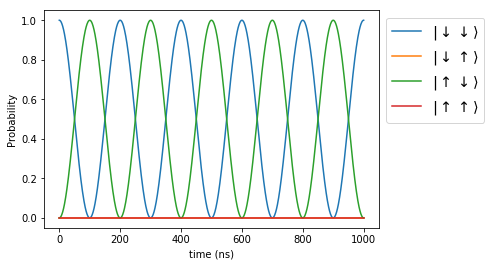

In [8]:
output = qt.mesolve(H,psi0,tlist,[],[],args=args,
                    options=qt.Options(nsteps=200000, method='bdf'),progress_bar=True)
plot_states(tlist,output)

In [15]:
tlist = np.linspace(0,50e-9,1000)
args = {'t0':4.3e9,'B_1':2e9, 'B_2' : 2e9, 'Bmw': 5e6, 
       'Bmw' : 5e6, 'viQ1': 0, 'vi' : 0, 'w_k': 2e9, 'w_driveq2': 2e9, 'tstart' : tlist[0], 
        'tstop' : tlist[-1]}

args = {'B1':2e9, 'B2':2e9, 'Bmw':5e6,'vi':0,'w_k':2e9,'t0':4.3e9,'det':0,'U1':1e12,'U2':1e12,'det':828.6e9
       ,'U1':1e12,'U2':1e12}

time_interval = '*(0e-9<=t<=50e-9)'#time interval

det = 'det*(10e-9<=t<=20e-9)'
HJ1c = '2*np.pi*t0**2*(1/(U1+'+det+')+1/(U2-'+det+'))'+time_interval
HJ2c = '-2*np.pi*np.exp(2j*2*np.pi*(B1-B2)/2*t)*t0**2*(1/(U1+'+det+')+1/(U2-'+det+'))'+time_interval
HJ3c = '-2*np.pi*np.exp(-2j*2*np.pi*(B1-B2)/2*t)*t0**2*(1/(U1+'+det+')+1/(U2-'+det+'))'+time_interval
H = [H0,[HJ1,HJ1c],[HJ2,HJ2c],[HJ3,HJ3c]]
psi0=qt.basis(4,1)


In [16]:
H0=set_Hamiltonian(0,0,0,850e9,840e9,0)#B1,B2,t,U1,U2,e
#detuning pulse
Hdet = set_Hamiltonian(0,0,0,1,-1,0)/(2*np.pi)
H0=qt.Qobj(H0)
Hdet = qt.Qobj(Hdet)
H0=qt.Qobj(np.zeros((4,4)))

In [12]:
#grover's algorithm
time_interval1='*(100e-9<=t<=225e-9)'
#microwavesignalrotatesqubit1withpi/2radiansBmwQ1*cos(w_driveQ1*t+viQ1)
Hmw_Q2_coeff_pulse_Q1_time1='-0.5*2*np.pi*BmwQ1*np.exp(1j*viQ1)*\
np.exp(1j*2*np.pi*(w_driveQ1-B2)*t)'+time_interval1
Hmw_Q2_conj_coeff_pulse_Q1_time1='-0.5*2*np.pi*BmwQ1*np.exp(-1j*viQ1)*\
np.exp(-1j*2*np.pi*(w_driveQ1-B2)*t)'+time_interval1
Hmw_Q1_coeff_pulse_Q1_time1='-0.5*2*np.pi*BmwQ1*np.exp(1j*viQ1)*\
np.exp(1j*2*np.pi*(w_driveQ1-B1)*t)'+time_interval1
Hmw_Q1_conj_coeff_pulse_Q1_time1='-0.5*2*np.pi*BmwQ1*np.exp(-1j*viQ1)*\
np.exp(-1j*2*np.pi*(w_driveQ1-B1)*t)'+time_interval1

#mwsignalrotatesqubit2withpi/2radiansBmwQ2*cos(w_driveQ2*t+viQ2)
Hmw_Q2_coeff_pulse_Q2_time1='-0.5*2*np.pi*BmwQ2*np.exp(1j*viQ2)*\
np.exp(1j*2*np.pi*(w_driveQ2-B2)*t)'+time_interval1
Hmw_Q2_conj_coeff_pulse_Q2_time1='-0.5*2*np.pi*BmwQ2*np.exp(-1j*viQ2)*\
np.exp(-1j*2*np.pi*(w_driveQ2-B2)*t)'+time_interval1
Hmw_Q1_coeff_pulse_Q2_time1='-0.5*2*np.pi*BmwQ2*np.exp(1j*viQ2)*\
np.exp(1j*2*np.pi*(w_driveQ2-B1)*t)'+time_interval1
Hmw_Q1_conj_coeff_pulse_Q2_time1='-0.5*2*np.pi*BmwQ2*np.exp(-1j*viQ2)*\
np.exp(-1j*2*np.pi*(w_driveQ2-B1)*t)'+time_interval1


#PulsestodetuningregimewhereJisnonzeroandhamiltonianreducestoCZ(Theoracle)
Hdet_c1='-2*np.pi*det*(225e-9<=t<=(275e-9+35e-9))'

#Startofgroverdiffusion(gd)
time_interval2='*(325e-9<=t<=450e-9)'
#RotateQ1
Hmw_Q2_coeff_pulse_Q1_time2='-0.5*2*np.pi*BmwQ1*np.exp(1j*viQ1_gd)*\
np.exp(1j*2*np.pi*(w_driveQ1-B2)*t)'+time_interval2
Hmw_Q2_conj_coeff_pulse_Q1_time2='-0.5*2*np.pi*BmwQ1*np.exp(-1j*viQ1_gd)*\
np.exp(-1j*2*np.pi*(w_driveQ1-B2)*t)'+time_interval2
Hmw_Q1_coeff_pulse_Q1_time2='-0.5*2*np.pi*BmwQ1*np.exp(1j*viQ1_gd)*\
np.exp(1j*2*np.pi*(w_driveQ1-B1)*t)'+time_interval2
Hmw_Q1_conj_coeff_pulse_Q1_time2='-0.5*2*np.pi*BmwQ1*np.exp(-1j*viQ1_gd)*\
np.exp(-1j*2*np.pi*(w_driveQ1-B1)*t)'+time_interval2
#RotateQ2
Hmw_Q2_coeff_pulse_Q2_time2='-0.5*2*np.pi*BmwQ2*np.exp(1j*viQ2_gd)*\
np.exp(1j*2*np.pi*(w_driveQ2-B2)*t)'+time_interval2
Hmw_Q2_conj_coeff_pulse_Q2_time2='-0.5*2*np.pi*BmwQ2*np.exp(-1j*viQ2_gd)*\
np.exp(-1j*2*np.pi*(w_driveQ2-B2)*t)'+time_interval2
Hmw_Q1_coeff_pulse_Q2_time2='-0.5*2*np.pi*BmwQ2*np.exp(1j*viQ2_gd)*\
np.exp(1j*2*np.pi*(w_driveQ2-B1)*t)'+time_interval2
Hmw_Q1_conj_coeff_pulse_Q2_time2='-0.5*2*np.pi*BmwQ2*np.exp(-1j*viQ2_gd)*\
np.exp(-1j*2*np.pi*(w_driveQ2-B1)*t)'+time_interval2

Hdet_c2='-2*np.pi*det*(451e-9<=t<=536e-9)'

#Anotherpi/2rotationtoundothesuperposition
time_interval3='*(560e-9<=t<=685e-9)'
#rotateQ1
Hmw_Q2_coeff_pulse_Q1_time3='-0.5*2*np.pi*BmwQ1*np.exp(1j*viQ1_undo)*\
np.exp(1j*2*np.pi*(w_driveQ1-B2)*t)'+time_interval3
Hmw_Q2_conj_coeff_pulse_Q1_time3='-0.5*2*np.pi*BmwQ1*np.exp(-1j*viQ1_undo)*\
np.exp(-1j*2*np.pi*(w_driveQ1-B2)*t)'+time_interval3
Hmw_Q1_coeff_pulse_Q1_time3='-0.5*2*np.pi*BmwQ1*np.exp(1j*viQ1_undo)*\
np.exp(1j*2*np.pi*(w_driveQ1-B1)*t)'+time_interval3
Hmw_Q1_conj_coeff_pulse_Q1_time3='-0.5*2*np.pi*BmwQ1*np.exp(-1j*viQ1_undo)*\
np.exp(-1j*2*np.pi*(w_driveQ1-B1)*t)'+time_interval3
#RotateQ2
Hmw_Q2_coeff_pulse_Q2_time3='-0.5*2*np.pi*BmwQ2*np.exp(1j*viQ2_undo)*\
np.exp(1j*2*np.pi*(w_driveQ2-B2)*t)'+time_interval3
Hmw_Q2_conj_coeff_pulse_Q2_time3='-0.5*2*np.pi*BmwQ2*np.exp(-1j*viQ2_undo)*\
np.exp(-1j*2*np.pi*(w_driveQ2-B2)*t)'+time_interval3
Hmw_Q1_coeff_pulse_Q2_time3='-0.5*2*np.pi*BmwQ2*np.exp(1j*viQ2_undo)*\
np.exp(1j*2*np.pi*(w_driveQ2-B1)*t)'+time_interval3
Hmw_Q1_conj_coeff_pulse_Q2_time3='-0.5*2*np.pi*BmwQ2*np.exp(-1j*viQ2_undo)*\
np.exp(-1j*2*np.pi*(w_driveQ2-B1)*t)'+time_interval3


time_int='*(0e-9<=t<=700e-9)'
det='det*((225e-9<=t<=(275e-9+35e-9))or(451e-9<=t<=536e-9))'

HJ1c='-2*np.pi*t0**2*(1/(U1+'+det+')+1/(U2-'+det+'))'+time_int
HJ2c='2*np.pi*np.exp(2j*2*np.pi*(B1-B2)/2*t)*t0**2*(1/(U1+'\
+det+')+1/(U2-'+det+'))'+time_int
HJ3c='2*np.pi*np.exp(-2j*2*np.pi*(B1-B2)/2*t)*t0**2*(1/(U1+'\
+det+')+1/(U2-'+det+'))'+time_int
c_ops = []
#c_ops.append(0.1*2e9*qt.Qobj(qt.tensor(qt.sigmax(),qt.qeye(2)).full()))
c_ops.append(0.1*2e-4*qt.Qobj(qt.tensor(qt.sigmaz(),qt.sigmaz()).full()))

In [13]:
phase_Q1=np.pi/2
phase_Q2=np.pi/2
tlist = np.linspace(0e-9,700e-9,1000)
args = {'det':828.6e9,'t0':0.190e9,'B1':19.7e9, 'B2' : 18.4e9, 'BmwQ1': 2e6, 
       'BmwQ2' : 2e6, 'viQ1': np.pi/2 ,'viQ2' : np.pi/2, 'viQ1_gd' : np.pi/2+phase_Q1, 'viQ2_gd':np.pi/2+phase_Q2,
        'viQ1_undo':np.pi+phase_Q1,'viQ2_undo':np.pi+phase_Q2, 'w_driveQ1': 19.7e9, 'w_driveQ2': 18.4e9, 'tstart' : tlist[0], 
        'tstop' : tlist[-1],'U1':850e9,'U2':840e9}

H=[H0,[Hmw1,Hmw_Q2_coeff_pulse_Q1_time1],[Hmw3,Hmw_Q2_conj_coeff_pulse_Q1_time1],[Hmw2,Hmw_Q1_coeff_pulse_Q1_time1],[Hmw4,Hmw_Q1_conj_coeff_pulse_Q1_time1],
  [Hmw1,Hmw_Q2_coeff_pulse_Q2_time1],[Hmw3,Hmw_Q2_conj_coeff_pulse_Q2_time1],[Hmw2,Hmw_Q1_coeff_pulse_Q2_time1],[Hmw4,Hmw_Q1_conj_coeff_pulse_Q2_time1],
  [Hmw1,Hmw_Q2_coeff_pulse_Q1_time2],[Hmw3,Hmw_Q2_conj_coeff_pulse_Q1_time2],[Hmw2,Hmw_Q1_coeff_pulse_Q1_time2],[Hmw4,Hmw_Q1_conj_coeff_pulse_Q1_time2],
  [Hmw1,Hmw_Q2_coeff_pulse_Q2_time2],[Hmw3,Hmw_Q2_conj_coeff_pulse_Q2_time2],[Hmw2,Hmw_Q1_coeff_pulse_Q2_time2],[Hmw4,Hmw_Q1_conj_coeff_pulse_Q2_time2],
  [Hmw1,Hmw_Q2_coeff_pulse_Q1_time3],[Hmw3,Hmw_Q2_conj_coeff_pulse_Q1_time3],[Hmw2,Hmw_Q1_coeff_pulse_Q1_time3],[Hmw4,Hmw_Q1_conj_coeff_pulse_Q1_time3],
  [Hmw1,Hmw_Q2_coeff_pulse_Q2_time3],[Hmw3,Hmw_Q2_conj_coeff_pulse_Q2_time3],[Hmw2,Hmw_Q1_coeff_pulse_Q2_time3],[Hmw4,Hmw_Q1_conj_coeff_pulse_Q2_time3],
  [HJ1,HJ1c],[HJ2,HJ2c],[HJ3,HJ3c]]

psi0=qt.basis(4,0)# evolve the |down, down> state\
start = time.time()
output = qt.mesolve(H,psi0,tlist,[],[],args=args,options=qt.Options(nsteps=120000),progress_bar=True)
print('total time: ', time.time()-start, 's')

E:\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Ahmad\Documents\GitHub\spin-projects\users\AhmadSJ\rhs143442.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


10.0%. Run time:   0.39s. Est. time left: 00:00:00:03
20.0%. Run time:   2.66s. Est. time left: 00:00:00:10
30.0%. Run time:   4.88s. Est. time left: 00:00:00:11
40.0%. Run time:   6.96s. Est. time left: 00:00:00:10
50.0%. Run time:   8.43s. Est. time left: 00:00:00:08
60.0%. Run time:  11.88s. Est. time left: 00:00:00:07
70.0%. Run time:  13.52s. Est. time left: 00:00:00:05
80.0%. Run time:  14.82s. Est. time left: 00:00:00:03
90.0%. Run time:  16.75s. Est. time left: 00:00:00:01
Total run time:  19.12s
total time:  37.38195204734802 s


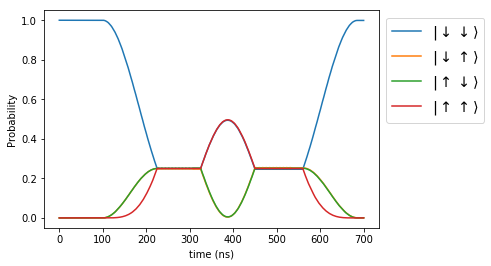

In [14]:

plot_states(tlist,output)